In [1]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
from all_funcs import mod_df
from all_funcs import add_factor
from all_funcs import three_graphs_one_plot
from all_funcs import fac_plots
from all_funcs import cap_outliers_by_list
from all_funcs import find_outliers_IQR
from all_funcs import ult_analysis
from all_funcs import test_mannwhitneyu
from all_funcs import siegel_tukey
from all_funcs import get_corr
from all_funcs import plot_pred
from all_funcs import train_test_split
from all_funcs import series_to_supervised
from all_funcs import pred_val
from all_funcs import graphs
from all_funcs import make_autocorr_plot
from all_funcs import make_autocorr_plot
# from all_funcs import persistence
# from all_funcs import make_forecasts
# from all_funcs import evaluate_forecasts
# from all_funcs import plot_forecasts
# from all_funcs import split_into_sequences
# from all_funcs import get_train_test_sets
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

In [2]:
dfs = []
for name in ['datasets\россия,-29006.xlsx', 'datasets\россия,-29007.xlsx' , 'datasets\россия,-29013.xlsx']:
  dfs.append(mod_df(name))

In [3]:
for i in range(len(dfs)):
  for name in ['datasets/rub-yield-curve-10y (1).xlsx', 'datasets/rucbcp3a3yns.xlsx', 'datasets/usd_rub-(fx) (1).xlsx', 'datasets/ставка-ruonia.xlsx']:
    dfs[i] = add_factor(dfs[i], name)
    dfs[i]['key_0'] = pd.to_datetime(dfs[i]['key_0'])
    dfs[i] = dfs[i].set_index('key_0')

In [4]:
dfs[1].head(3)

,Indicative,YTM Indicative,G-spread,t,ISIN,name,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,,,
2022-01-03,101.6825,12.9435,463.741270,1,RU000A0JV4M0,"datasets\россия,-29007.xlsx",8.3678,100.51,74.58064,8.13
2022-01-04,101.9825,12.8652,456.058849,2,RU000A0JV4M0,"datasets\россия,-29007.xlsx",8.3704,100.72,75.16675,8.13
2022-01-05,102.0735,12.8446,457.275971,3,RU000A0JV4M0,"datasets\россия,-29007.xlsx",8.3386,100.80,76.11534,8.13


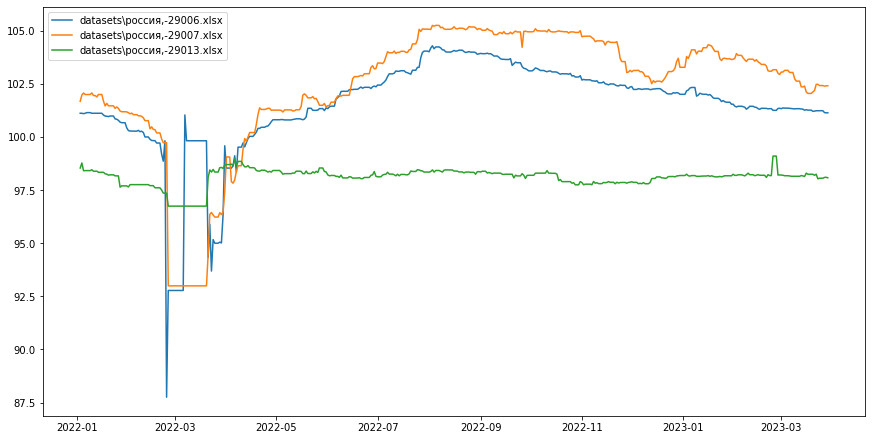

In [5]:
three_graphs_one_plot(dfs[0], dfs[1], dfs[2])

In [6]:
df_alph_full = dfs[0][dfs[0].index >= '2022-05-01']
df_alph_full['t'] = [i for i in range(len(df_alph_full))]

C:\Temp\ipykernel_12204\613649094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alph_full['t'] = [i for i in range(len(df_alph_full))]


In [7]:
df_alph_full.head(2)

,Indicative,YTM Indicative,G-spread,t,ISIN,name,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,,,
2022-05-01,100.8145,13.8102,410.382466,0,RU000A0JV4L2,"datasets\россия,-29006.xlsx",10.3225,95.97,73.35063,16.56
2022-05-02,100.8145,13.8102,410.382466,1,RU000A0JV4L2,"datasets\россия,-29006.xlsx",10.3225,95.97,70.92121,16.56


<AxesSubplot:xlabel='key_0'>

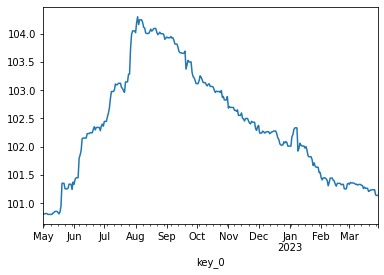

In [8]:
df_alph_full['Indicative'].plot()

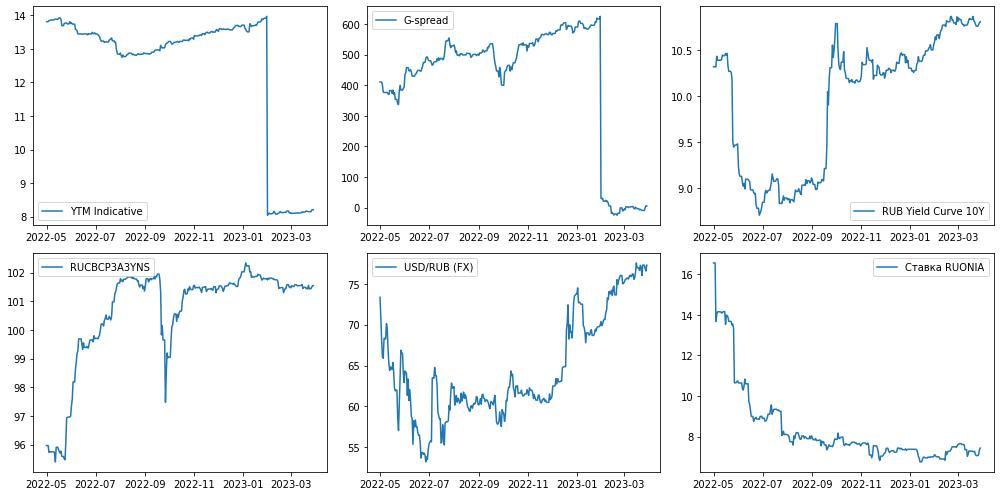

In [9]:
fac_plots(df_alph_full)

In [10]:
df_alph = df_alph_full.copy()

In [11]:
outliers = {}
for name in df_alph.select_dtypes(include = numerics).columns:
  outliers['{}'.format(name)] = find_outliers_IQR(df_alph[name])

for name in df_alph.select_dtypes(include = numerics).columns:
  if len(outliers[name]) > 0:
    df_alph[name] = cap_outliers_by_list(df_alph[name])

for name in df_alph.select_dtypes(include = numerics).columns:
    df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name] = cap_outliers_by_list(df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name])

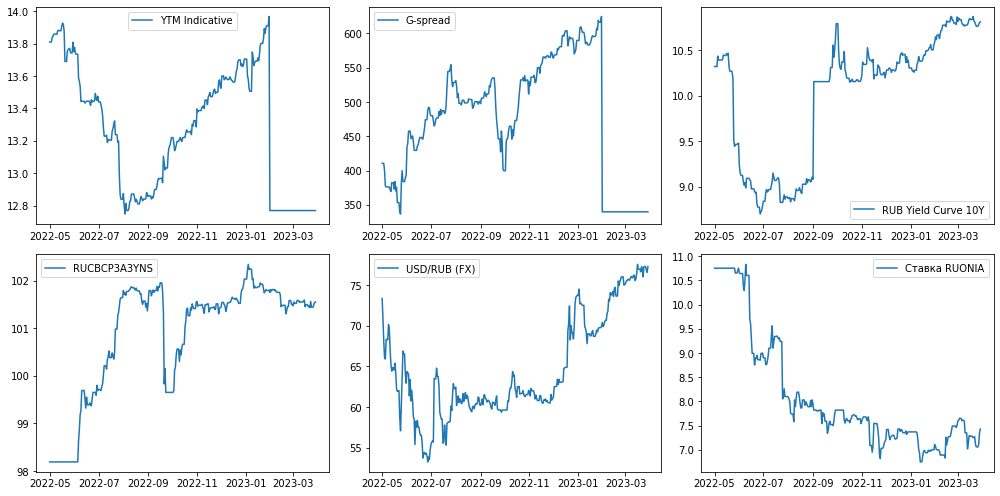

In [12]:
fac_plots(df_alph)

MSE = 0.003123


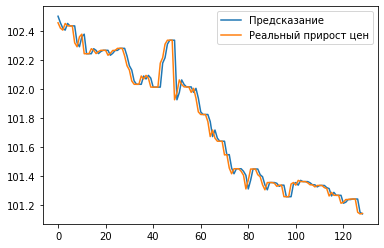

In [13]:
pred_val(df_alph_full['Indicative'][204:], df_alph_full['Indicative'][203:].shift(1).dropna())

MSE = 0.006065


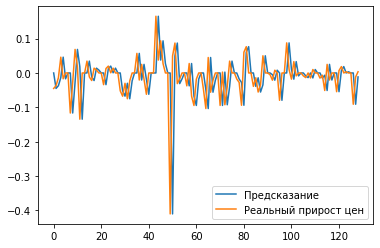

In [74]:
#Тривиальная модель

from sklearn.metrics import mean_squared_error

pred_val((df_alph_full['Indicative'][203:] - df_alph_full['Indicative'][203:].shift(1)).dropna(), (df_alph_full['Indicative'][202:].shift(1) - df_alph_full['Indicative'][202:].shift(2)).dropna())


### Linear models

In [15]:
siegel_tukey(df_alph['Indicative'])
test_mannwhitneyu(df_alph['Indicative'])

z value: -7.275
Probably different distributions
stat=2.04e+04, p=2.04e+04
Probably different distributions


In [16]:
df_alph['Indicative'] = df_alph['Indicative'] - df_alph['Indicative'].shift(1)
df_alph_uni = df_alph[['Indicative', 't']]
df_alph_uni = df_alph_uni[1:]

In [17]:
df_alph_uni.head(3)

,Indicative,t
key_0,,
2022-05-02,0.000,1
2022-05-03,0.000,2
2022-05-04,0.009,3


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_alph_uni['t'], df_alph_uni['Indicative'], 130)

In [19]:
import statsmodels.api as sm

X_lm = sm.add_constant(X_train)
regr = sm.OLS(y_train, X_lm)
regr2 = regr.fit()
print(regr2.summary())

                            OLS Regression Results                            
Dep. Variable:             Indicative   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     13.70
Date:                Mon, 22 May 2023   Prob (F-statistic):           0.000277
Time:                        20:07:35   Log-Likelihood:                 235.01
No. Observations:                 202   AIC:                            -466.0
Df Residuals:                     200   BIC:                            -459.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0428      0.011      3.987      0.0

MSE = 0.004595


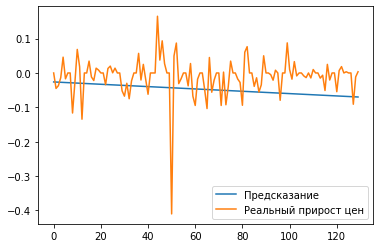

In [20]:
# from sklearn.linear_model import LinearRegression

# model = LinearRegression().fit(X_train, y_train)
prediction = regr2.predict(sm.add_constant(X_test))

# print('MSE = %.4g' % mean_squared_error((y_test+df_alph_full['Indicative'][202:].shift(1)[1:]), (prediction+df_alph_full['Indicative'][202:].shift(1)[1:])))

# plot_pred(prediction+df_alph_full['Indicative'][202:].shift(1)[1:], y_test+df_alph_full['Indicative'][202:].shift(1)[1:])

print('MSE = %.4g' % mean_squared_error(y_test, prediction))

plot_pred(prediction, y_test)

### ARIMA

c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


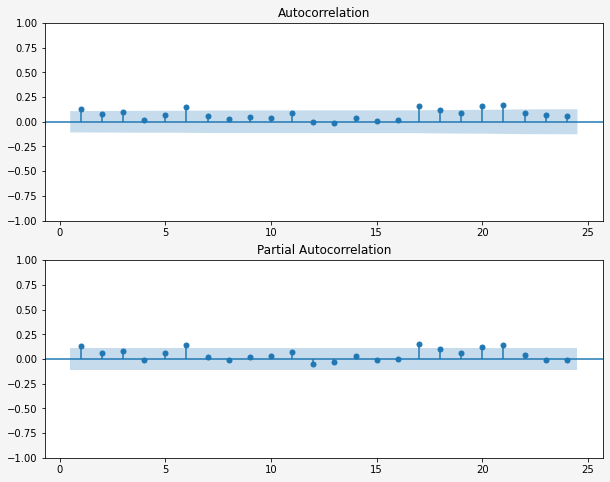

In [21]:
make_autocorr_plot(df_alph_uni['Indicative'])

In [22]:
train = df_alph_uni['Indicative'][:203]
test = df_alph_uni['Indicative'][203:]

In [23]:
arima_model = ARIMA(train, order = (1,0,0))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             Indicative   No. Observations:                  203
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 232.287
Date:                Mon, 22 May 2023   AIC                           -458.573
Time:                        20:07:35   BIC                           -448.634
Sample:                    05-02-2022   HQIC                          -454.552
                         - 11-20-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.007      1.126      0.260      -0.006       0.023
ar.L1          0.1514      0.056      2.680      0.007       0.041       0.262
sigma2         0.0059      0.000     22.575      0.0

c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MSE = 0.003365


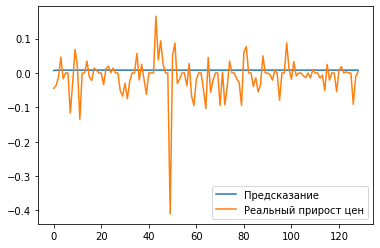

In [24]:
prediction = model.forecast(129)

print('MSE = %.4g' % mean_squared_error(test, prediction))

plot_pred(prediction, test)

### LSTM

In [25]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
 names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
 if i == 0:
  names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
 else:
  names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
  agg.dropna(inplace=True)
 return agg


def persistence(last_ob, n_seq):
 return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = np.sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
                
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	plt.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i
		off_e = off_s + len(forecasts[i])
		xaxis = [x for x in range(off_s, off_e)]
		plt.plot(xaxis, forecasts[i], color='red')
	# show the plot
	plt.show()

In [26]:
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    X_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    X_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return X_train, y_train, X_test, y_test

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
price = df_alph_full['Indicative'].values.reshape(-1, 1)
scaled_price = scaler.fit_transform(price)

In [28]:
seq_len = 60

# x_train, y_train, x_test, y_test = get_train_test_sets(scaled_price, seq_len, train_frac=0.9)
x_train, y_train, x_test, y_test = get_train_test_sets(df_alph['Indicative'][1:].values.reshape(-1, 1), seq_len, train_frac=0.525)


In [29]:
len(y_test)

130

In [30]:
# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))

In [31]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/10
8/8 [==============================] - 10s 423ms/step - loss: 0.0080 - val_loss: 0.0033
Epoch 2/10
8/8 [==============================] - 1s 108ms/step - loss: 0.0075 - val_loss: 0.0034
Epoch 3/10
8/8 [==============================] - 1s 116ms/step - loss: 0.0065 - val_loss: 0.0032
Epoch 4/10
8/8 [==============================] - 1s 104ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 5/10
8/8 [==============================] - 1s 108ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 6/10
8/8 [==============================] - 1s 102ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 7/10
8/8 [==============================] - 1s 102ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 8/10
8/8 [==============================] - 1s 115ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 9/10
8/8 [==============================] - 1s 130ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 10/10
8/8 [==============================] - 1s 124ms/step - loss: 0.0060 - val_loss: 0.0031


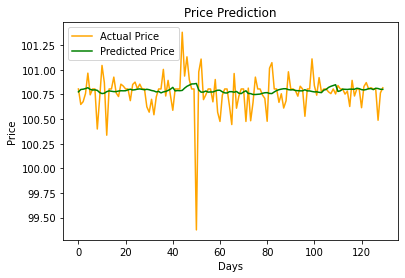

In [32]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted Price', color='green')
 
plt.title('Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show()

MSE = 0.003198


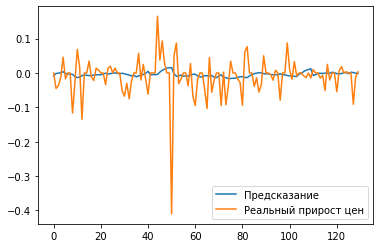

In [33]:
pred_val(y_test, y_pred)

### Multivariate models

In [34]:
df_alph = df_alph_full.copy()
df_alph = df_alph.select_dtypes(include=numerics)

In [35]:
df_alph.head(5)

,Indicative,YTM Indicative,G-spread,t,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,
2022-05-01,100.8145,13.8102,410.382466,0,10.3225,95.97,73.35063,16.56
2022-05-02,100.8145,13.8102,410.382466,1,10.3225,95.97,70.92121,16.56
2022-05-03,100.8145,13.8102,410.382466,2,10.3225,95.97,68.13433,16.56
2022-05-04,100.8235,13.8381,400.315639,3,10.3203,95.73,66.08850,13.68
2022-05-05,100.8215,13.8455,377.537108,4,10.4369,95.75,65.88899,14.00


In [36]:
outliers = {}
for name in df_alph.select_dtypes(include = numerics).columns:
  outliers['{}'.format(name)] = find_outliers_IQR(df_alph[name])

for name in df_alph.select_dtypes(include = numerics).columns:
  if len(outliers[name]) > 0:
    df_alph[name] = cap_outliers_by_list(df_alph[name])

for name in df_alph.select_dtypes(include = numerics).columns:
    df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name] = cap_outliers_by_list(df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name])

In [37]:
# df_alph['Indicative'] = np.exp(df_alph['Indicative'])
# for name in df_alph.columns:
#     df_alph[name] = np.log(df_alph[name])
# df_alph['YTM Indicative'] = np.log(df_alph['YTM Indicative'])
# df_alph['USD/RUB (FX)'] = np.log(df_alph['USD/RUB (FX)'])
# df_alph['Ставка RUONIA'] = np.log(df_alph['Ставка RUONIA'])


In [38]:
df_alph = (df_alph - df_alph.shift(1)).dropna()

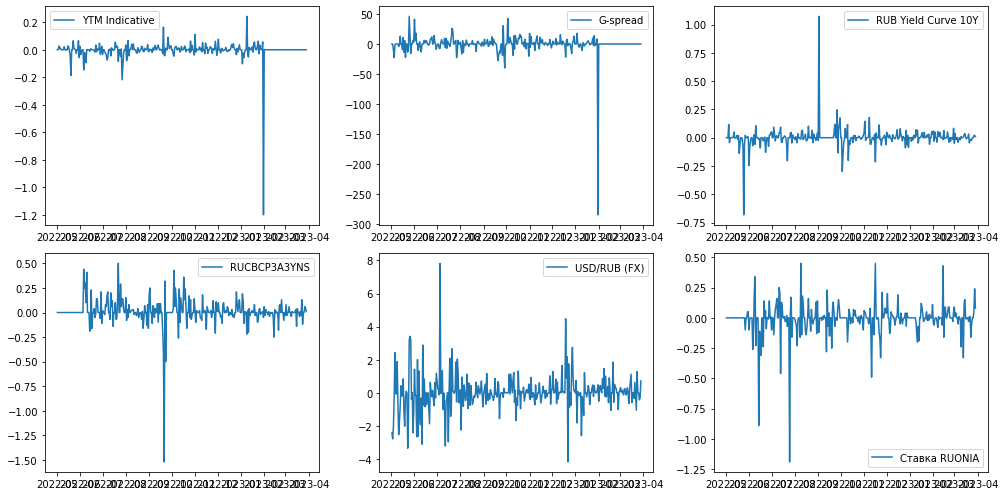

In [39]:
fac_plots(df_alph)

In [40]:
df_alph['t'] = [i for i in range(len(df_alph))]

In [41]:
df_alph

,Indicative,YTM Indicative,G-spread,t,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,
2022-05-02,0.0000,0.0000,0.000000,0,0.0000,0.00,-2.42942,0.00
2022-05-03,0.0000,0.0000,0.000000,1,0.0000,0.00,-2.78688,0.00
2022-05-04,0.0090,0.0279,-10.066826,2,-0.0022,0.00,-2.04583,0.00
2022-05-05,-0.0020,0.0074,-22.778531,3,0.1166,0.00,-0.19951,0.00
2022-05-06,-0.0155,0.0137,-1.521917,4,-0.0436,0.00,2.42426,0.00
...,...,...,...,...,...,...,...,...
2023-03-25,0.0000,0.0000,0.000000,327,0.0000,0.00,0.00000,0.00
2023-03-26,0.0000,0.0000,0.000000,328,0.0000,0.00,0.00000,0.00
2023-03-27,-0.0910,0.0000,0.000000,329,0.0176,0.06,-0.42570,0.05


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332 entries, 2022-05-02 to 2023-03-29
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Indicative           332 non-null    float64
 1   YTM Indicative       332 non-null    float64
 2   G-spread             332 non-null    float64
 3   t                    332 non-null    int64  
 4   RUB Yield Curve 10Y  332 non-null    float64
 5   RUCBCP3A3YNS         332 non-null    float64
 6   USD/RUB (FX)         332 non-null    float64
 7   Ставка RUONIA        332 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 23.3 KB
None
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 1
Indicative             0
YTM Indicative         0
G-spread               0
t                      0
RUB Yield Curve 10Y    0
RUCBCP3A3YNS           0
USD/RUB (FX)           0
Ставка RUONIA          0
dtype: int64
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

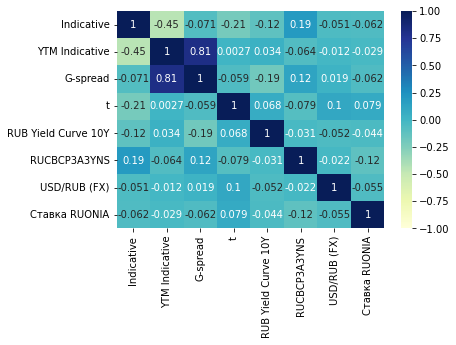

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 4
key_0
2022-05-19    0.1025
2022-05-20    0.4070
2022-05-23   -0.0960
2022-05-27    0.0705
2022-05-30   -0.0940
2022-05-31    0.1315
2022-06-02    0.0860
2022-06-06    0.3460
2022-06-08    0.0785
2022-06-09    0.2100
2022-06-14    0.0770
2022-06-28    0.0805
2022-07-01    0.0845
2022-07-04    0.0780
2022-07-06    0.0925
2022-07-07    0.1655
2022-07-08    0.1270
2022-07-12    0.1040
2022-07-18   -0.0725
2022-07-22    0.1845
2022-07-25    0.1360
2022-07-27    0.4530
2022-07-28    0.2460
2022-08-02    0.1740
2022-08-03    0.1075
2022-08-04   -0.1395
2022-08-05    0.0850
2022-08-09   -0.0865
2022-08-11   -0.0880
2022-08-30   -0.0785
2022-09-20   -0.3180
2022-09-21    0.0765
2022-09-22    0.0780
2022-09-26   -0.1840
2022-09-27   -0.0755
2022-10-04    0.0850
2022-10-26   -0.1195
2022-11-01   -0.2030
2022-11-11   -0.0975
2022-11-15   -0.0895
2022-11-28   -0.1165
2022-11-30    0.0685
2022-12-02   -0.1345
2022-12-22   -0.0750
2023-01-03

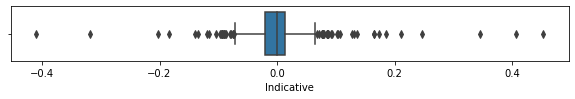

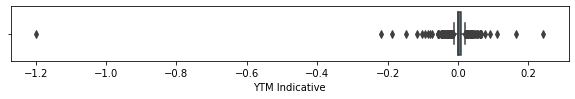

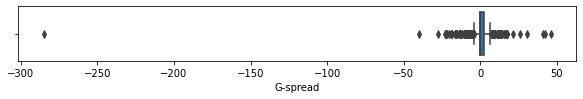

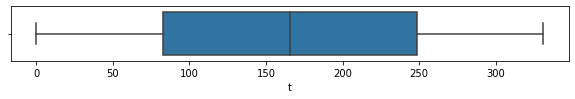

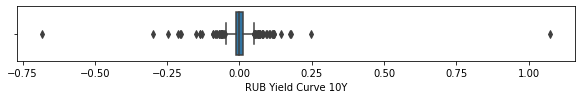

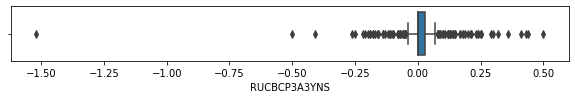

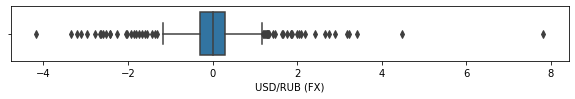

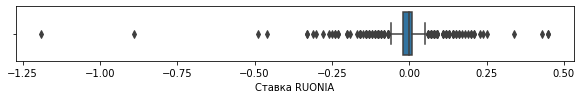

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 6


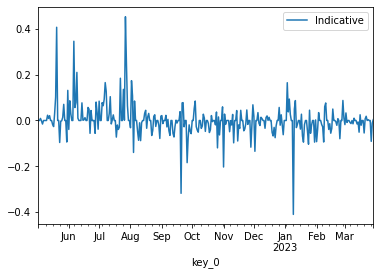

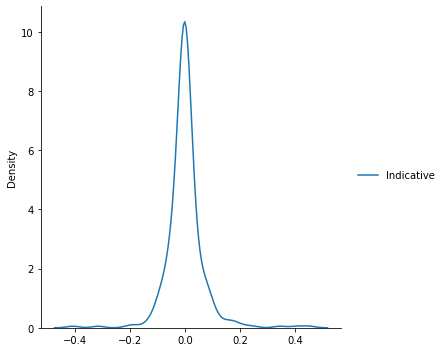

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 7
Тест Jarque Bera
        JB         p-value        skew             kurtosis     
----------------------------------------------------------------
2734.6716599139945     0.0 1.0538223942632572 16.901256827747158
----------------------------------------------------------------

Тест Шапиро-Уилк
Statistics=0.768, p-value=0.000
Отклонить гипотезу о нормальности
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 8
Тест Jarque Bera
        JB         p-value        skew             kurtosis     
----------------------------------------------------------------
2734.6716599139945     0.0 1.0538223942632572 16.901256827747158
----------------------------------------------------------------

Тест Шапиро-Уилк
Statistics=0.768, p-value=0.000
Отклонить гипотезу о нормальности
None


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


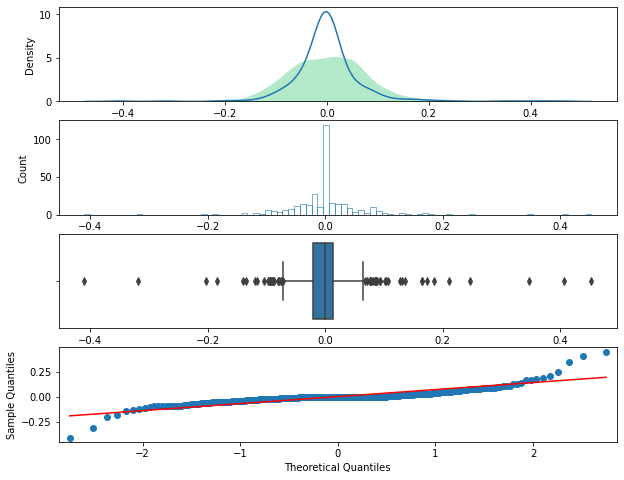

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 9


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


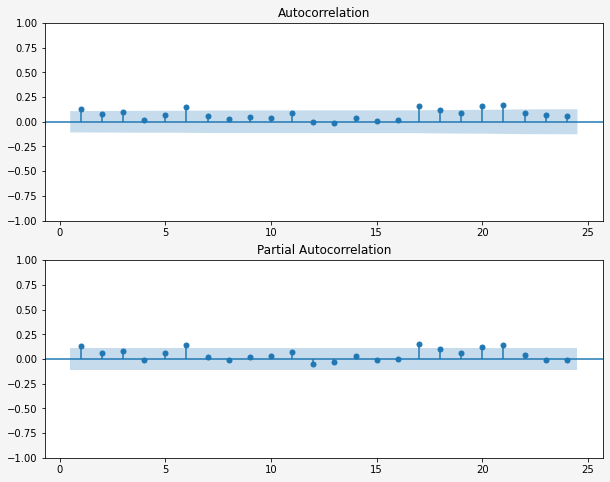

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 10
Тестирование средних. Статистика Стьюдента: 0.2563780886939599. Критическое значение: 1.6541409762941324
Тестирование дисперсий. Статистика Фишера: 0.4270382397674385. Критическое значение: 1.2928419282151524
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 11
excess kurtosis of normal distribution (should be 0): 13.901256827747158
skewness of normal distribution (should be 0): 1.0538223942632572


In [42]:
ult_analysis(df_alph)

In [43]:
siegel_tukey(df_alph['Indicative'])
test_mannwhitneyu(df_alph['Indicative'])

z value: -2.220
Probably different distributions
stat=1.61e+04, p=1.61e+04
Probably different distributions


C:\Temp\ipykernel_12204\3445508651.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corrmat_significance.values[[np.arange(corrmat_significance.shape[0])]*2] = 0


<AxesSubplot:>

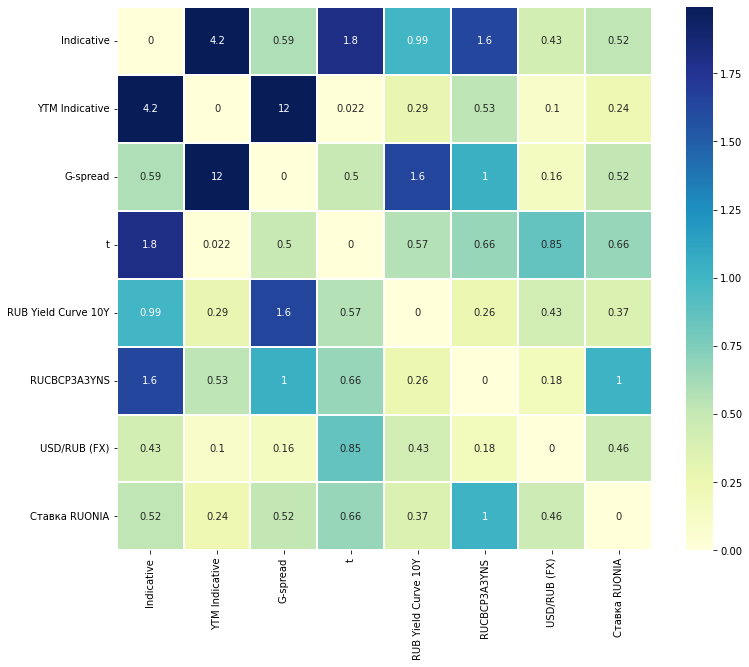

In [44]:
corrmat = df_alph.corr(method='pearson')

corrmat_significance = np.abs(corrmat/np.sqrt(1-np.power(corrmat,2))*np.sqrt(70))
corrmat_significance.values[[np.arange(corrmat_significance.shape[0])]*2] = 0

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat_significance, ax=ax, cmap="YlGnBu", linewidths=0.1, annot=True, vmax=1.994)

### Feature selection

In [45]:
X = df_alph.drop('Indicative', axis = 1).select_dtypes(include=numerics)
Y = df_alph['Indicative']

In [46]:
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X, Y)
set_printoptions(precision=3)
print(fit.scores_)

[1.165 1.19  0.879 1.703 1.796 2.612 6.226]


In [47]:
X.columns

Index(['YTM Indicative', 'G-spread', 't', 'RUB Yield Curve 10Y',
       'RUCBCP3A3YNS', 'USD/RUB (FX)', 'Ставка RUONIA'],
      dtype='object')

In [48]:
alph_feat = df_alph[['Indicative', 'YTM Indicative', 'G-spread', 'RUCBCP3A3YNS']]

## Modeling

### Random forest

In [49]:
X = alph_feat.drop('Indicative', axis = 1)
y = alph_feat['Indicative']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 130)

In [51]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args

n_features = X.shape[1]

reg = XGBRegressor(n_estimators=50, random_state=0)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train,  cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4], res_gp.x[5]))


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Best score=0.0137
Best parameters:
- max_depth=1
- learning_rate=0.255210
- max_features=1
- min_samples_split=100
- min_samples_leaf=1
- n_estimators=39


MSE = 0.001983


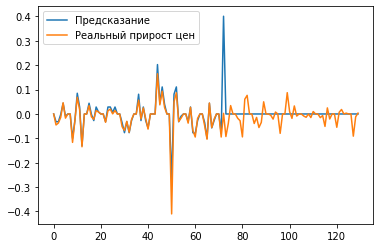

In [67]:

regressor = XGBRegressor(max_depth=1, learning_rate=0.255210, max_features=1, min_samples_split=100, min_samples_leaf=1, n_estimators=39)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [53]:
n_features = X.shape[1]

reg = RandomForestRegressor(n_estimators=50, random_state=0)
space  = [Integer(1, 5, name='max_depth'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train,  cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4]))


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best score=0.0143
Best parameters:
- max_depth=5
- max_features=3
- min_samples_split=2
- min_samples_leaf=1
- n_estimators=88


MSE = 0.002233


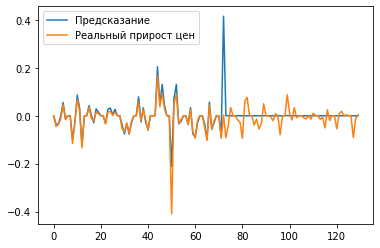

In [68]:

regressor = RandomForestRegressor(max_depth=5, max_features=3, min_samples_split=2, min_samples_leaf=1, n_estimators=88)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [55]:
# X = df_alph_full[['Indicative', 'G-spread', 'RUB Yield Curve 10Y', 'USD/RUB (FX)']].drop('Indicative', axis = 1)
# y = df_alph_full[['Indicative', 'G-spread', 'RUB Yield Curve 10Y', 'USD/RUB (FX)']]['Indicative'] 

# X_train, X_test, y_train, y_test = train_test_split(X, y, 130)

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

n_features = X.shape[1]

reg = GradientBoostingRegressor(n_estimators=50, random_state=0)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train,  cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4], res_gp.x[5]))


Best score=0.0139
Best parameters:
- max_depth=3
- learning_rate=0.103384
- max_features=3
- min_samples_split=100
- min_samples_leaf=1
- n_estimators=100


MSE = 0.002207


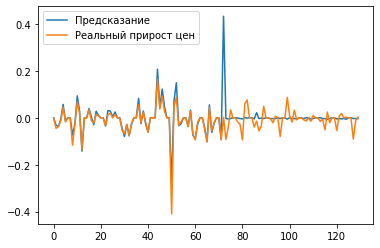

In [69]:

regressor = GradientBoostingRegressor(max_depth=3, learning_rate=0.103384, max_features=3, min_samples_split=100, min_samples_leaf=1, n_estimators=100)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [58]:
from sklearn.ensemble import HistGradientBoostingRegressor

reg = HistGradientBoostingRegressor()
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2]))


Best score=0.0139
Best parameters:
- max_depth=1
- learning_rate=0.091070
- min_samples_leaf=1


MSE = 0.002069


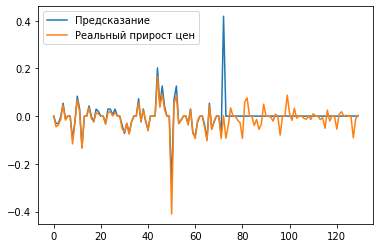

In [70]:
regressor = HistGradientBoostingRegressor(max_depth=1, learning_rate=0.091070, min_samples_leaf=1)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [71]:
from sklearn.ensemble import AdaBoostRegressor

reg = AdaBoostRegressor(loss = 'linear')
space  = [Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- learning_rate=%.6f
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1]))


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best score=0.0160
Best parameters:
- learning_rate=1.000000
- n_estimators=77


MSE = 0.002346


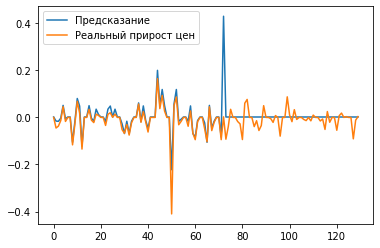

In [72]:
regressor = AdaBoostRegressor(loss = 'linear', learning_rate=1, n_estimators=77)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [62]:
from lineartree           import LinearBoostRegressor

reg = LinearBoostRegressor(base_estimator=LinearRegression(), loss = 'linear')
space  = [Integer(1, 5, name='max_depth'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train,  cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4]))

Best score=0.0107
Best parameters:
- max_depth=4
- max_features=2
- min_samples_split=14
- min_samples_leaf=57
- n_estimators=99


MSE = 0.04848


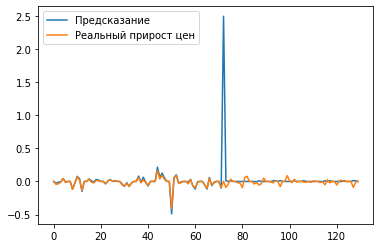

In [73]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 max_depth=4, max_features=2, min_samples_split=14, min_samples_leaf=57, n_estimators=99)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

### Метод главных компонент

In [64]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

#для удобства создадим датафрейм без столбца даты и целевого значения

df11 = df_alph.loc[:, df_alph.columns!='Indicative'].select_dtypes(include=numerics)

#для работы методом главных компонент необходимо нормализировать данные

df1 = preprocessing.normalize(df11)
df1 = pd.DataFrame(df1, columns = df11.columns)

[0.73 1.   1.   1.   1.   1.  ]


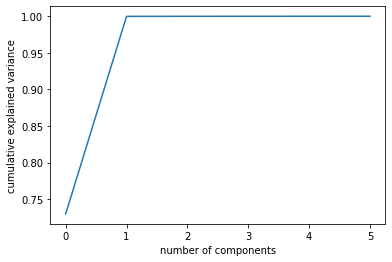

In [65]:
pca = PCA().fit(df1.drop('USD/RUB (FX)', axis = 1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print(np.cumsum(pca.explained_variance_ratio_))

In [66]:
df_alph[1:]['Indicative']

key_0
2022-05-03    0.0000
2022-05-04    0.0090
2022-05-05   -0.0020
2022-05-06   -0.0155
2022-05-07    0.0000
               ...  
2023-03-25    0.0000
2023-03-26    0.0000
2023-03-27   -0.0910
2023-03-28   -0.0115
2023-03-29    0.0035
Name: Indicative, Length: 331, dtype: float64